# ImageCLEF Medical Caption Task 2019

The Image CLEF 2019 Concept Detection Task is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by Unified Medical Language System (UMLS) concept IDs.

The AUEB NLP Group won the competition with this paper. This assignment was prepared by Vasiliki Kougia and John Pavlopoulos.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

#preferred style
plt.style.use('ggplot')

import numpy as np
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

Read the labels

In [19]:
string_consepts = 'ImageCLEF2019/string_concepts.csv'
train_consepts = 'ImageCLEF2019/train_concepts.csv'
val_concepts = 'ImageCLEF2019/val_concepts.csv'

str_con = pd.read_csv(string_consepts, sep='\t', header=None)
train_con = pd.read_csv(train_consepts)
val_con = pd.read_csv(val_concepts)

In [20]:
train_con

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743
...,...,...
56624,ROCO_CLEF_40405,C0040395;C0034579;C0015450;C0040405
56625,ROCO_CLEF_17150,C0286840;C3244287
56626,ROCO_CLEF_04341,C0699900;C1553386;C0728863;C0182400;C0042779;C...
56627,ROCO_CLEF_36569,C0023890;C0441633;C3263723


Let's plot some images

In [21]:
training_set = 'ImageCLEF2019/training-set/'
test_set = 'ImageCLEF2019/test-set/'
validation_set = 'ImageCLEF2019/validation-set/'

* Let's discover some of the training images

* What we need is a method that brings the tags given an image

In [22]:
# add header to str_con
str_con.rename(columns={0: 'tag', 1: 'tag_name'}, inplace=True)

In [23]:
# method that grabs all the tag names for the tag string given
def fetch_tags(tag):
    tags = tag.split(';')
    ids = []
    names = []
    for tag in tags:
        ids.append(tag)
        index = str_con.loc[str_con.tag == tag]
        names.append(index.tag_name.values[0])
    return ids, names

Let's see some radiology images and the abnormality related to it 

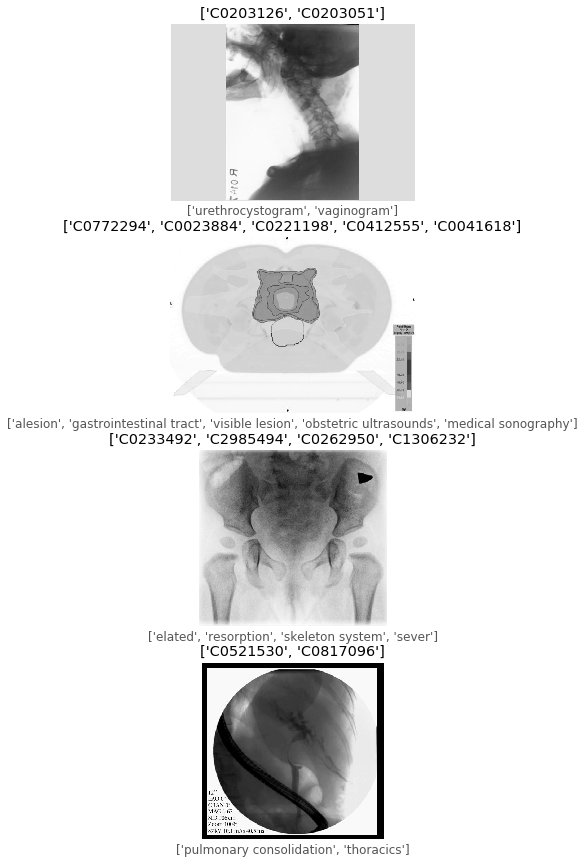

In [24]:
plt.figure(figsize=(15,15))
for index, i in enumerate(os.listdir(training_set)[:4]):
    img = cv2.imread(training_set + i,0)
    plt.subplot(4,1,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    ids, names = fetch_tags(train_con.iloc[index, 1])
    _ = plt.title(ids)
    _ = plt.xlabel(names)

In [25]:
# train = []

# time1 = time.time()   # to measure time taken

# # Load in the images
# for filepath in os.listdir(training_set):
#     instances = cv2.imread(training_set + filepath, 0)
#     train.append(instances)
    
# print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# # train = np.array(train, dtype="float") / 255.0

In [26]:
# test = []

# time1 = time.time()   # to measure time taken

# # Load in the images
# for filepath in os.listdir(test_set):
#     instances = cv2.imread(test_set + filepath, 0)
#     test.append(instances)
    
# print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# # train = np.array(train, dtype="float") / 255.0

In [27]:
# validation_setdation = []

# time1 = time.time()   # to measure time taken

# # Load in the images
# for filepath in os.listdir(validation_set):
#     instances = cv2.imread(validation_set + filepath, 0)
#     validation.append(instances)
    
# print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
    
# # train = np.array(train, dtype="float") / 255.0

### How many tags are there in total?

# TODO:
* The minimum num-ber of concepts per training image is 1, and the maximum is 72 (according to the paper)

#### Training

In [28]:
tags = val_con.iloc[:, 1]

In [29]:
sum_of_tags = 0
for tag in tags:
    items = tag.split(';')
    sum_of_tags += len(items)    

In [30]:
sum_of_tags

86927

which is the most frequent one?

In [31]:
# method that counts all the tag_ids and
# puts the in a dictionary
tag_dic = {}
for tag in tags:
    items = tag.split(';')
    for item in items:
        if item not in tag_dic.keys():
            tag_dic[item] = 1
        else:
            tag_dic[item] += 1

In [32]:
tag_df = pd.DataFrame.from_dict(tag_dic, orient='index', columns=['tag_count'])

get the tag_name column

In [33]:
str_con

,tag,tag_name
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...
...,...,...
5523,C0044955,prednylidene (pred)
5524,C3812869,medicated
5525,C2751430,camptodactyly and knuckle pads
5526,C0441621,sampled


In [34]:
tag_df = pd.merge(tag_df, str_con, left_index=True, right_on='tag', how='inner')

In [35]:
tag_df.reset_index(inplace=True)
tag_df.drop(columns=['index'], inplace=True)

In [36]:
tag_df.sort_values(by=['tag_count'], ascending=False, inplace=True)

In [37]:
tag_df

,tag_count,tag,tag_name
40,1692,C0441633,diagnostic scanning
24,1585,C0043299,x-ray procedure
23,1584,C1962945,radiogr
18,1489,C0817096,thoracics
20,1462,C0040395,tomogr
...,...,...,...
2341,1,C0159075,milky urine
2342,1,C0180453,laryngoscope
2343,1,C0192232,pharyngoscopy
2344,1,C0023072,laryngoscopies


In [38]:
first_ten = tag_df[:10]

In [39]:
reverse = first_ten[::-1]

In [40]:
reverse

,tag_count,tag,tag_name
88,1165,C0221198,visible lesion
86,1165,C0772294,alesion
124,1269,C1548003,radiograph
21,1363,C0040405,x-ray computer assisted tomography
16,1437,C0034579,pantomogr
20,1462,C0040395,tomogr
18,1489,C0817096,thoracics
23,1584,C1962945,radiogr
24,1585,C0043299,x-ray procedure
40,1692,C0441633,diagnostic scanning


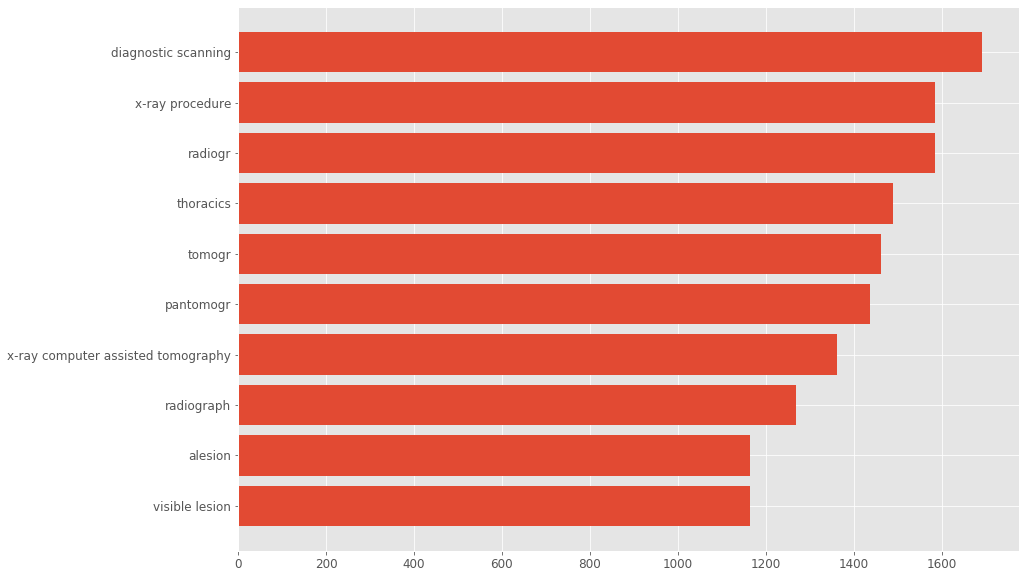

In [41]:
MEDIUM_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)     # fontsize of the axes title
plt.figure(figsize=[14, 10])
_ = plt.barh(reverse.tag_name[:10], width=reverse.tag_count[:10])

Lets now create an image generator

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [44]:
batch_size = 128
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 225

## Data Preprocessing
 

We might want to
* change the images to filenames
* change the train_con tags to a list so the classes are separated

In [45]:
train_con_list = train_con.copy()
train_con_list['tags'] = train_con_list['tags'].apply(lambda x:x.split(';'))
train_con_list['image'] = train_con_list['image'].apply(lambda x:x + ('.jpg'))

In [46]:
valid_con_list = val_con.copy()
valid_con_list['tags'] = valid_con_list['tags'].apply(lambda x:x.split(';'))
valid_con_list['image'] = valid_con_list['image'].apply(lambda x:x + ('.jpg'))

In [47]:
valid_con_list.head()

,image,tags
0,ROCO_CLEF_64017.jpg,"[C0001074, C3203359, C0041618]"
1,ROCO_CLEF_39073.jpg,"[C0027530, C1610719, C0065967, C1704258, C0883..."
2,ROCO_CLEF_18028.jpg,"[C1265876, C1293134, C0029053, C0034579, C0025..."
3,ROCO_CLEF_02052.jpg,"[C0040426, C1962945, C0043299, C0036849, C0150..."
4,ROCO_CLEF_67927.jpg,"[C0184666, C4085643, C4049705, C4049706, C4321..."


In [48]:
train_con_list.head()

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"


In [49]:
classes = list(str_con.tag)

## Generators

In [50]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_con_list,
                                                           directory=training_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 56629 validated image filenames belonging to 5528 classes.


In [51]:
valid_data_gen = validation_image_generator.flow_from_dataframe(dataframe=valid_con_list,
                                                           directory=validation_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 14157 validated image filenames belonging to 5528 classes.


In [38]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(5528, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 225, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)       

In [40]:
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

# STEP_SIZE_TRAIN = 3
# STEP_SIZE_VALID = 3

history = model.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=STEP_SIZE_VALID
)

Epoch 1/5
442/442 [==============================] - 2792s 6s/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.0070 - val_accuracy: 0.9989
Epoch 2/5
442/442 [==============================] - 3850s 9s/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.0067 - val_accuracy: 0.9989
Epoch 3/5
442/442 [==============================] - 3480s 8s/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 4/5
442/442 [==============================] - 3509s 8s/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.0070 - val_accuracy: 0.9989
Epoch 5/5
442/442 [==============================] - 3762s 9s/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0077 - val_accuracy: 0.9989


In [41]:
# save model
model.save('cnn_v1.h5')

## After training

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

#preferred style
plt.style.use('ggplot')

import numpy as np
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

In [52]:
## load model
from keras.models import load_model
model = load_model('models/cnn_v1.h5')

Trying to create the candidate and ground truth files

In [84]:
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

valid_data_gen.reset()
pred=model.predict(valid_data_gen,
steps=STEP_SIZE_VALID,
verbose=1)

110/110 [==============================] - 135s 1s/step


In [85]:
pred.shape

(14080, 5528)

In [86]:
val_con.shape

(14157, 2)

In [83]:
pred

array([[1.9348632e-05, 3.5619600e-05, 4.9490329e-05, ..., 1.0810676e-05,
        1.0485935e-05, 4.7502449e-06],
       [4.2100905e-07, 1.2407000e-05, 4.2234844e-04, ..., 6.2698467e-07,
        5.7348376e-07, 2.5116711e-07],
       [2.5421843e-07, 1.6313927e-04, 3.2070614e-03, ..., 3.7790215e-07,
        2.3705121e-07, 1.8226116e-07],
       ...,
       [1.2393489e-05, 2.1454347e-05, 1.3167239e-04, ..., 8.4373905e-06,
        7.6018932e-06, 4.2796187e-06],
       [2.1241682e-07, 4.2419115e-06, 3.6990924e-03, ..., 2.4448934e-07,
        2.8185619e-07, 1.9990142e-07],
       [7.4560057e-07, 1.1126679e-04, 3.1893051e-04, ..., 1.1312768e-06,
        5.5835022e-07, 4.3624212e-07]], dtype=float32)

Let's try another model architecture

In [4]:
# string_consepts = 'ImageCLEF2019/string_concepts.csv'
# train_consepts = 'ImageCLEF2019/train_concepts.csv'
# val_concepts = 'ImageCLEF2019/val_concepts.csv'

# str_con = pd.read_csv(string_consepts, sep='\t', header=None)
# train_con = pd.read_csv(train_consepts)
# val_con = pd.read_csv(val_concepts)

In [5]:
# valid_con_list = val_con.copy()
# valid_con_list['tags'] = valid_con_list['tags'].apply(lambda x:x.split(';'))
# valid_con_list['image'] = valid_con_list['image'].apply(lambda x:x + ('.jpg'))

In [6]:
# train_con_list = train_con.copy()
# train_con_list['tags'] = train_con_list['tags'].apply(lambda x:x.split(';'))
# train_con_list['image'] = train_con_list['image'].apply(lambda x:x + ('.jpg'))

Resources:
    
* https://github.com/JNYH/Project_Kojak
* https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24